# Performance Comparison of Deep Learning Frameworks

## Image Preprocessing

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv, time, os.path
from six.moves import cPickle
from sklearn import model_selection as ms

In [2]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath, size, training=True):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 43 classes
    if training:
        for c in range(0,43):
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            gtReader.next() # skip header
            # loop over all images in current annotations file
            for row in gtReader:
#                 image = Image.open(prefix + row[0]).convert('L') # Load an image and convert to grayscale
                image = Image.open(prefix + row[0])
                box = (int(row[3]), int(row[4]), int(row[5]), int(row[6])) # Specify ROI box
                image = image.crop(box) # Crop the ROI
                image = image.resize(size) # Resize images
                images.append(np.asarray(image).astype('uint8')) # the 1th column is the filename, while 3,4,5,6 are the vertices of ROI
                labels.append(int(row[7])) # the 8th column is the label
            gtFile.close()
    else:
        gtFile = open(rootpath + "/../../GT-final_test.csv") # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
#             image = Image.open(rootpath + '/' + row[0]).convert('L') # Load an image and convert to grayscale
            image = Image.open(rootpath + '/' + row[0]) # Color version
            box = (int(row[3]), int(row[4]), int(row[5]), int(row[6])) # Specify ROI box
            image = image.crop(box) # Crop the ROI
            image = image.resize(size) # Resize images
            images.append(np.asarray(image).astype('uint8')) # the 1th column is the filename, while 3,4,5,6 are the vertices of ROI
            labels.append(int(row[7])) # the 8th column is the label
        gtFile.close()
        
    return images, labels

In [21]:
from sys import platform
global root
global epoch_num
if platform == "darwin":
    root = "/Users/moderato/Downloads/GTSRB/try"
else:
    root = "/home/zhongyilin/Desktop/GTSRB/try"
print(root)
train_dir = root + "/Final_Training/Images"
test_dir = root + "/Final_Test/Images"
resize_size = (49, 49)
epoch_num = 5

/Users/moderato/Downloads/GTSRB/try


trainImages list length 39209, trainLabels list length 39209
testImages list length 12630, testLabels list length 12630
(49, 49, 3)


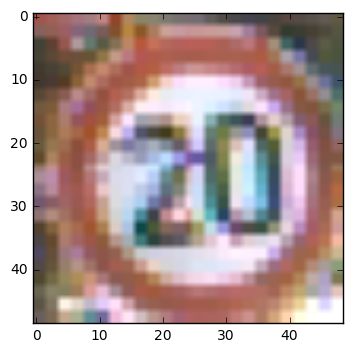

(49, 49, 3)


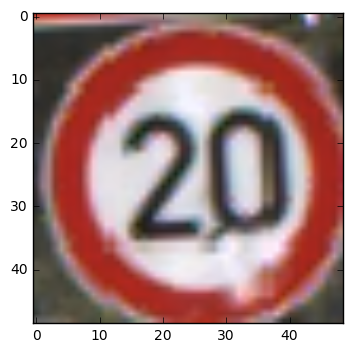

In [4]:
trainImages, trainLabels, testImages, testLabels = None, None, None, None

## If pickle file exists, read the file
if os.path.isfile(root + "/processed_images.pkl"):
    f = open(root + "/processed_images.pkl", 'rb')
    trainImages = cPickle.load(f, encoding="latin1")
    trainLabels = cPickle.load(f, encoding="latin1")
    testImages = cPickle.load(f, encoding="latin1")
    testLabels = cPickle.load(f, encoding="latin1")
    f.close()
## Else, read images and write to the pickle file
else:
    start = time.time()
    trainImages, trainLabels = readTrafficSigns(train_dir, resize_size)
    print("Training Image preprocessing finished in {:.2f} seconds".format(time.time() - start))

    start = time.time()
    testImages, testLabels = readTrafficSigns(test_dir, resize_size, False)
    print("Testing Image preprocessing finished in {:.2f} seconds".format(time.time() - start))
    
    f = open(root + "/processed_images.pkl", 'wb')
    for obj in [trainImages, trainLabels, testImages, testLabels]:
        cPickle.dump(obj, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

print("trainImages list length {:d}, trainLabels list length {:d}".format(len(trainImages), len(trainLabels)))
print("testImages list length {:d}, testLabels list length {:d}".format(len(testImages), len(testLabels)))

print(trainImages[42].shape)
plt.imshow(trainImages[42])
plt.show()

print(testImages[21].shape)
plt.imshow(trainImages[21])
plt.show()

## Intel Nervana Neon

In [5]:
from neon.backends import gen_backend
from neon.initializers import Gaussian, Constant, GlorotUniform
from neon.layers import GeneralizedCost, Affine
from neon.layers import Conv as neon_Conv, Dropout as neon_Dropout, Pooling as neon_Pooling
from neon.transforms import Rectlin, Softmax, CrossEntropyMulti, Misclassification, TopKMisclassification
from neon.models import Model
from neon.optimizers import GradientDescentMomentum as neon_SGD, ExpSchedule
from neon.callbacks.callbacks import Callbacks, LossCallback
from neon.data.dataiterator import ArrayIterator

mlp = None

if os.path.isfile(root + "/saved_models/neon_weights.prm"):
    print("Model exists")
else:
    # Set up backend
    be = gen_backend(batch_size=128)

    # Make iterators
    x_train, x_valid, neon_y_train, neon_y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)
    neon_train_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in x_train]), y=np.asarray(neon_y_train), nclass=43, lshape=(3, resize_size[0], resize_size[1]))
    neon_valid_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in x_valid]), y=np.asarray(neon_y_valid), nclass=43, lshape=(3, resize_size[0], resize_size[1]))

    # Construct CNN
    neon_gaussInit = Gaussian(loc=0.0, scale=0.01)
    layers = []
    layers.append(neon_Conv((5, 5, 64), strides=2, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="conv1"))
    layers.append(neon_Pooling(2, strides=2, name="pool1"))
    layers.append(neon_Conv((3, 3, 256), strides=1, padding=1, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="conv2"))
    layers.append(neon_Pooling(2, strides=2, name="pool2"))
    layers.append(Affine(nout=4096, init=GlorotUniform(), bias=Constant(0.0), activation=Rectlin()))
    layers.append(neon_Dropout(keep=0.5))
    layers.append(Affine(nout=43, init=neon_gaussInit, bias=Constant(0.0), activation=Softmax()))

    # Initialize model object
    mlp = Model(layers=layers)

    # Costs
    neon_cost = GeneralizedCost(costfunc=CrossEntropyMulti())

    # Learning rules
    neon_optimizer = neon_SGD(0.01, momentum_coef=0.9, schedule=ExpSchedule(0.2))

    # Callbacks: validate on validation set
    callbacks = Callbacks(mlp, eval_set=neon_valid_set, output_file=root+"/callback_data.h5")
    callbacks.add_callback(LossCallback(eval_set=neon_valid_set, epoch_freq=1))

    # Fit
    start = time.time()
    mlp.fit(neon_train_set, optimizer=neon_optimizer, num_epochs=epoch_num, cost=neon_cost, callbacks=callbacks)
    print("Neon training finishes in {:.2f} seconds.".format(time.time() - start))

    # Result
    results = mlp.get_outputs(neon_valid_set)

ImportError: No module named 'neon'

In [ ]:
# Print error
start = time.time()
neon_error_mis = mlp.eval(neon_valid_set, metric=Misclassification())*100
print('Misclassification error = {:.1f}%. Finished in {:.2f} seconds.'.format(neon_error_mis[0], time.time() - start))

start = time.time()
neon_error_top3 = mlp.eval(neon_valid_set, metric=TopKMisclassification(3))*100
print('Top 3 Misclassification error = {:.1f}%. Finished in {:.2f} seconds.'.format(neon_error_top3[2], time.time() - start))

# First try:
# Learning rate 0.01 for 20 epochs ends up with 23.9% and 10.4%
# Learning rate 0.005 for 20 extra epochs ends up with 9.9% and 3.6%
# Learning rate 0.001 for 10 extra epochs ends up with 7.1% and 2.4%
# Learning rate 0.0005 for 10 extra epochs ends up with 6.6% and 2.3%

mlp.save_params(root + "/saved_models/neon_weights.prm")

In [ ]:
# Print error on test set
neon_test_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in testImages]), y=np.asarray(testLabels), nclass=43, lshape=(3, resize_size[0], resize_size[1]))

start = time.time()
neon_error_mis_t = mlp.eval(neon_test_set, metric=Misclassification())*100
print('Misclassification error = {:.1f}% on test set. Finished in {:.2f} seconds.'.format(neon_error_mis_t[0], time.time() - start))

start = time.time()
neon_error_top3_t = mlp.eval(neon_test_set, metric=TopKMisclassification(3))*100
print('Top 3 Misclassification error = {:.1f}% on test set. Finished in {:.2f} seconds.'.format(neon_error_top3_t[2], time.time() - start))

# First try:
# Final evaluation on test set ends up with 16.6% and 8.2%
# Reason why this is higher than above: images extracted from video streams, and valid set is more similar to train set than test set.

## Keras with different multiple backends (Tensorflow, Theano, CNTK)

In [6]:
from keras.layers import Conv2D as keras_Conv, MaxPooling2D as keras_MaxPooling, GlobalAveragePooling2D as keras_AveragePooling
from keras.layers import Dropout as keras_Dropout, Dense, Flatten
from keras.models import Sequential
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing import image
from keras.initializers import RandomNormal, glorot_uniform, Constant as keras_Constant
from keras.optimizers import SGD as keras_SGD
from keras.callbacks import ModelCheckpoint, Callback as keras_callback
from sklearn import model_selection as ms
from sklearn.preprocessing import OneHotEncoder
import os

Using TensorFlow backend.


In [7]:
class LossHistory(keras_callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [8]:
# Function to dynamically change keras backend
from importlib import reload
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

In [ ]:
backends = ["theano", "tensorflow"]
if platform != "darwin":
    backends.append("cntk")
    
for b in backends:
    set_keras_backend(b)

    # Load and process images
    enc = OneHotEncoder(sparse=False)
    x_train, x_valid, y_train, y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)
    keras_train_set = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in x_train])
    keras_valid_set = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in x_valid])
    keras_test_set = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in testImages])
    keras_y_train = enc.fit_transform(np.array(y_train, dtype=int).reshape(-1,1))
    keras_y_valid = enc.fit_transform(np.array(y_valid, dtype=int).reshape(-1,1))
    keras_y_test = enc.fit_transform(np.array(testLabels, dtype=int).reshape(-1,1))

    # Build model
    keras_gaussInit = RandomNormal(mean=0.0, stddev=0.01, seed=542)
    glorotUniform = glorot_uniform(seed=542)

    keras_model = Sequential()
    keras_model.add(keras_Conv(64, (5, 5), kernel_initializer=keras_gaussInit, strides=(2, 2), bias_initializer=keras_Constant(0.0), activation="relu", input_shape=(resize_size[0], resize_size[1], 3)))
    keras_model.add(keras_MaxPooling(pool_size=(2, 2)))
    keras_model.add(keras_Conv(256, (3, 3), kernel_initializer=keras_gaussInit, strides=(2, 2), padding="same", bias_initializer=keras_Constant(0.0), activation="relu"))
    keras_model.add(keras_MaxPooling(pool_size=(2, 2)))
    keras_model.add(Flatten()) # An extra layer to flatten the previous layer in order to connect to fully connected layer
    keras_model.add(Dense(4096, kernel_initializer=glorotUniform, bias_initializer=keras_Constant(0.0), activation="relu"))
    keras_model.add(keras_Dropout(0.5))
    keras_model.add(Dense(43, kernel_initializer=keras_gaussInit, bias_initializer=keras_Constant(0.0), activation="softmax"))
#     keras_model.summary()

    keras_optimizer = keras_SGD(lr=0.01, decay=1.6e-8, momentum=0.9)
    keras_cost = "categorical_crossentropy"
    keras_model.compile(loss=keras_cost, optimizer=keras_optimizer, metrics=["acc"])

    checkpointer = ModelCheckpoint(filepath=root+"/saved_models/keras_"+b+"_weights.hdf5",
                                       verbose=1, save_best_only=True)

    start = time.time()
    keras_model.fit(keras_train_set, keras_y_train,
                  validation_data=(keras_valid_set, keras_y_valid),
                  epochs=epoch_num, batch_size=128, callbacks=[checkpointer, LossHistory()], verbose=1)
    print("{} training finishes in {:.2f} seconds.".format(b, time.time() - start))

    keras_model.load_weights(root+"/saved_models/keras_"+b+"_weights.hdf5")
    keras_predictions = [np.argmax(keras_model.predict(np.expand_dims(feature, axis=0))) for feature in keras_test_set]

    # report test accuracy
    keras_test_accuracy = 100*np.sum(np.array(keras_predictions)==np.argmax(keras_y_test, axis=1))/len(keras_predictions)
    print('{} test accuracy: {:.1f}%'.format(b, keras_test_accuracy))